**Multivariate Air Quality Forecasting Using Deep Learning Models: A Case Study on Delhi Pollution**

By Akash P R (B210775EE)

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df = pd.read_csv('city_hour.csv')
df

#Filtering only Delhi rows from the Kaggle Dataset
df = df[df['City'] == 'Delhi'].copy()
print(df.head())
print(df.info())

         City             Datetime   PM2.5    PM10      NO    NO2     NOx  \
245172  Delhi  2015-01-01 01:00:00  454.58  935.18   81.52  41.78  187.66   
245173  Delhi  2015-01-01 02:00:00  440.44     NaN   70.80  43.46  176.83   
245174  Delhi  2015-01-01 03:00:00  409.09     NaN  132.46  41.19  141.02   
245175  Delhi  2015-01-01 04:00:00  436.12     NaN   84.78  39.55  102.84   
245176  Delhi  2015-01-01 05:00:00  415.88  976.99   60.24  37.41   80.12   

          NH3     CO   SO2     O3  Benzene  Toluene  Xylene  AQI AQI_Bucket  
245172  27.54   9.29  3.41  54.94    25.24    58.57   13.80  NaN        NaN  
245173  27.72  13.28  3.88  50.53    23.10    49.37   15.63  NaN        NaN  
245174  28.94  29.67  2.83  19.33    19.04    38.94   17.18  NaN        NaN  
245175  29.30  21.76  4.33  20.08    13.99    27.53   16.82  NaN        NaN  
245176  30.84  26.19  6.17  16.00    11.14    21.99   14.29  NaN        NaN  
<class 'pandas.core.frame.DataFrame'>
Index: 48192 entries, 245172 to

In [51]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.set_index('Datetime')  # To Make datetime the index for time-series modeling
df = df.sort_index()  # To Ensure it's in time order

In [52]:
print(df.isnull().sum()) #for checking the missing and null data

City              0
PM2.5           375
PM10           2421
NO              298
NO2             330
NOx              25
NH3             980
CO              364
SO2            2852
O3             2201
Benzene          38
Toluene          26
Xylene        18904
AQI             498
AQI_Bucket      498
dtype: int64


In [53]:
missing_percent = df.isnull().mean() * 100 # Missing percentage
print(missing_percent.sort_values(ascending=False))

Xylene        39.226428
SO2            5.917995
PM10           5.023655
O3             4.567148
NH3            2.033533
AQI            1.033367
AQI_Bucket     1.033367
PM2.5          0.778137
CO             0.755312
NO2            0.684761
NO             0.618360
Benzene        0.078851
Toluene        0.053951
NOx            0.051876
City           0.000000
dtype: float64


In [54]:
df = df.interpolate(method='time')  # or 'linear' Interpolation of missing data
df = df.fillna(method='ffill').fillna(method='bfill')  # backup

<ipython-input-54-56222fe0855d>:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate(method='time')  # or 'linear'
<ipython-input-54-56222fe0855d>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')  # backup


In [55]:
selected_features = ['PM2.5', 'PM10', 'NO2', 'CO', 'O3']
df = df[selected_features]

In [56]:
print(df.isnull().sum()) #for checking the missing and null data

PM2.5    0
PM10     0
NO2      0
CO       0
O3       0
dtype: int64


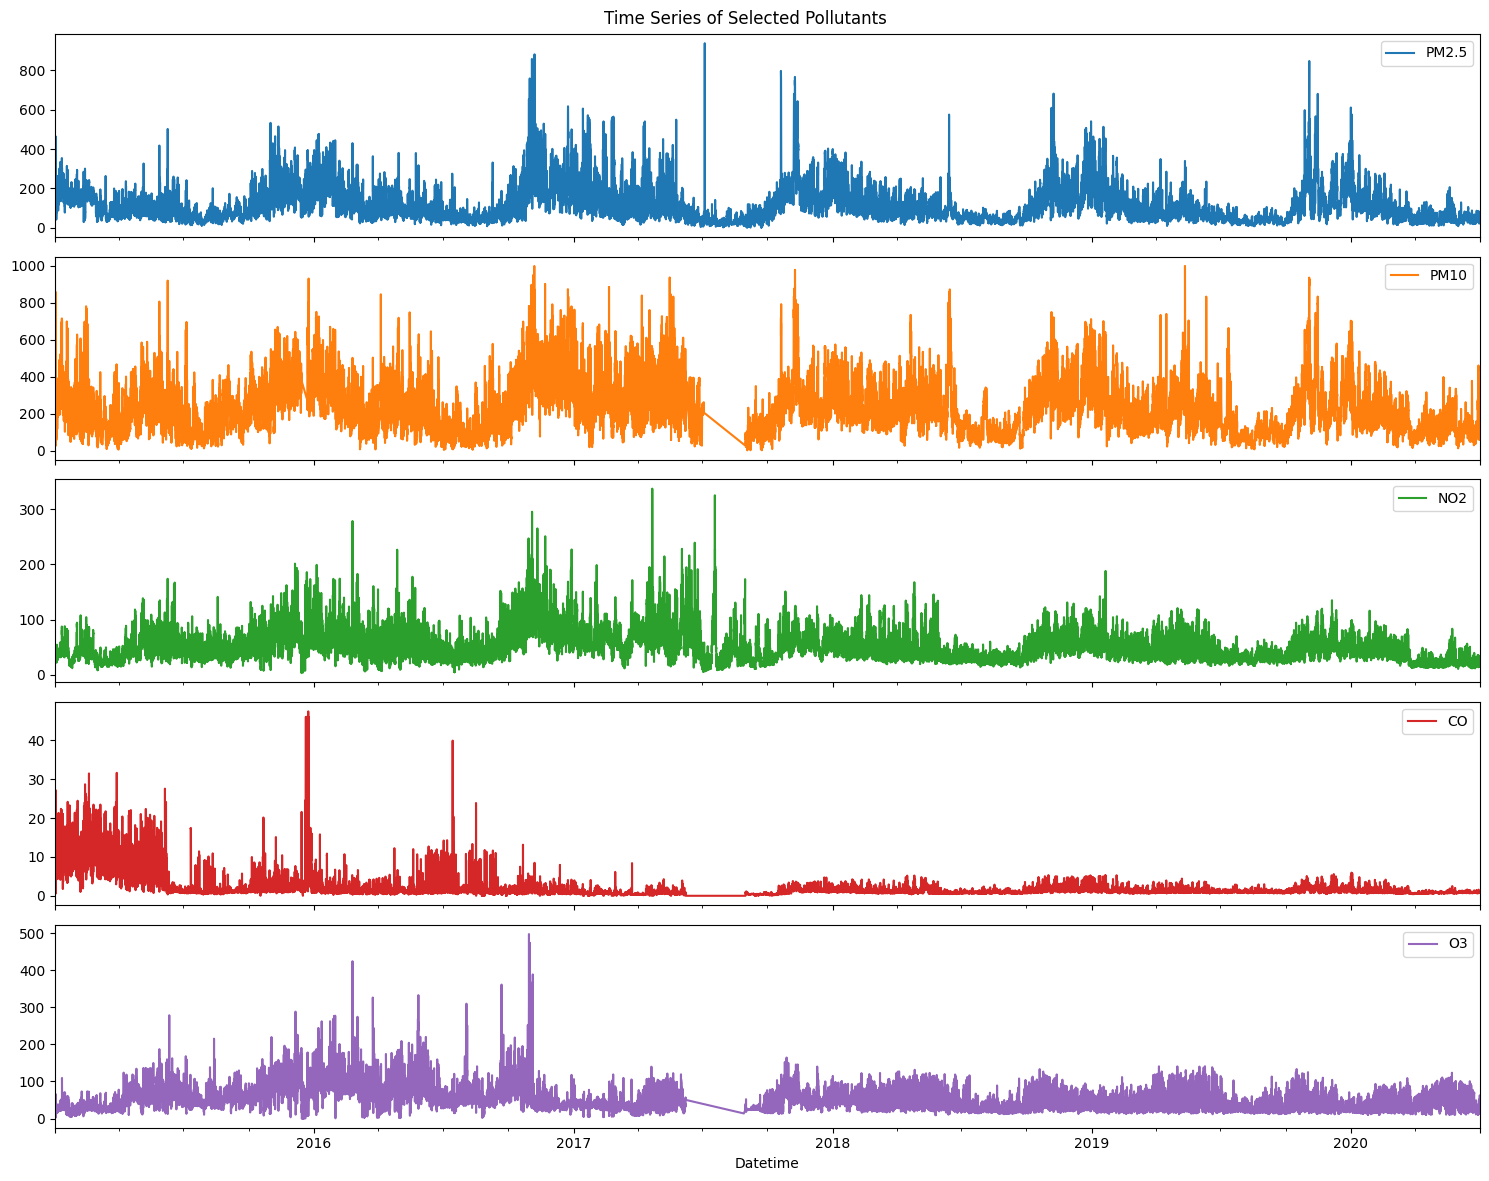

In [57]:
df.plot(subplots=True, figsize=(15, 12), title='Time Series of Selected Pollutants')
plt.tight_layout()
plt.show()

In [58]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Convert back to DataFrame for easier handling
scaled_df = pd.DataFrame(scaled_data, index=df.index, columns=df.columns)

In [59]:
# Add lag features
for col in df.columns:
    scaled_df[f'{col}_lag1'] = scaled_df[col].shift(1)
    scaled_df[f'{col}_lag2'] = scaled_df[col].shift(2)

# Add moving average features
for col in df.columns:
    scaled_df[f'{col}_ma3'] = scaled_df[col].rolling(window=3).mean()
    scaled_df[f'{col}_ma7'] = scaled_df[col].rolling(window=7).mean()

# Drop rows with NaNs after shifting/rolling
scaled_df.dropna(inplace=True)

In [60]:
import numpy as np
def create_sliding_window(data, target_col='PM2.5', window_size=24, forecast_horizon=1):
    X, y = [], []
    for i in range(len(data) - window_size - forecast_horizon + 1):
        X.append(data.iloc[i:i+window_size].values)
        y.append(data.iloc[i+window_size+forecast_horizon-1][target_col])
    return np.array(X), np.array(y)

X, y = create_sliding_window(scaled_df, target_col='PM2.5', window_size=24, forecast_horizon=1)

In [61]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

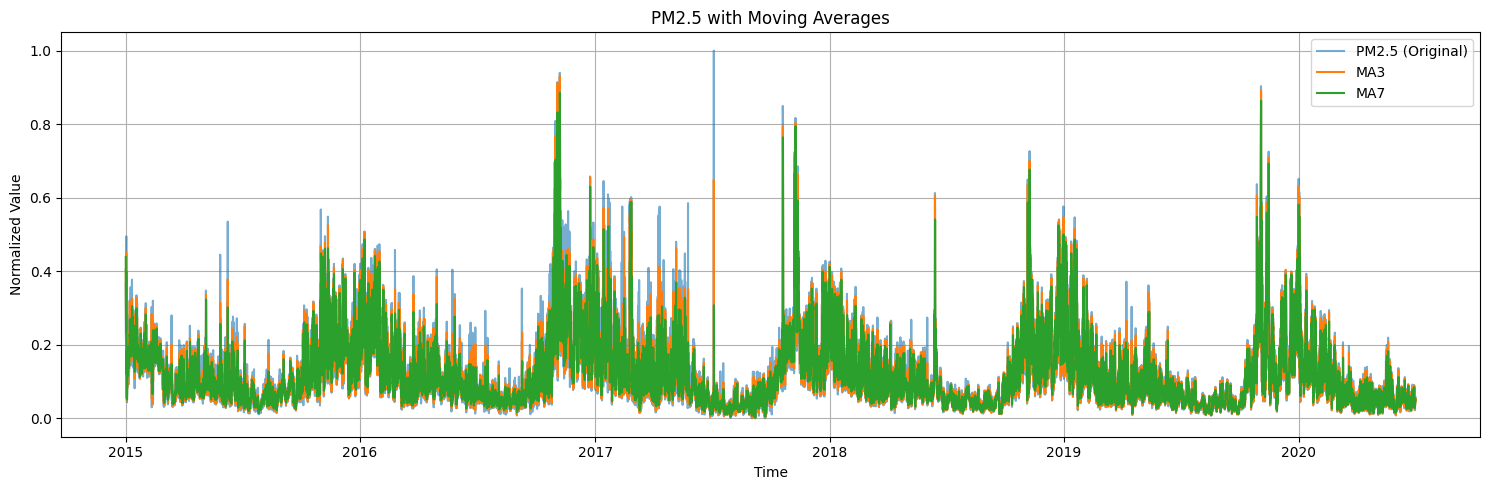

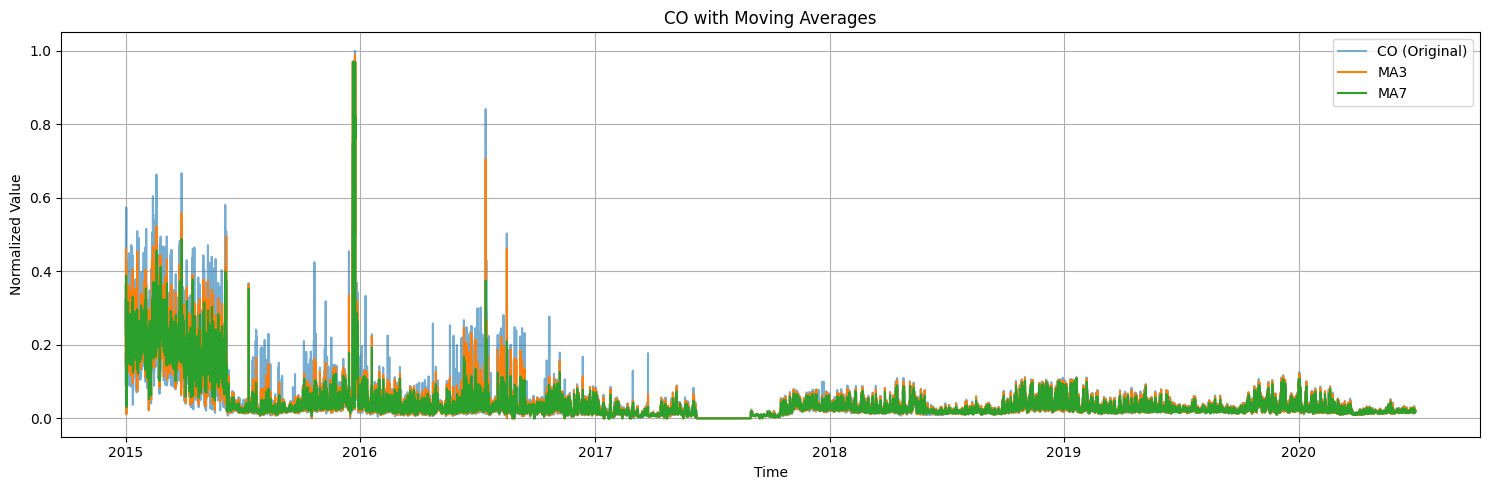

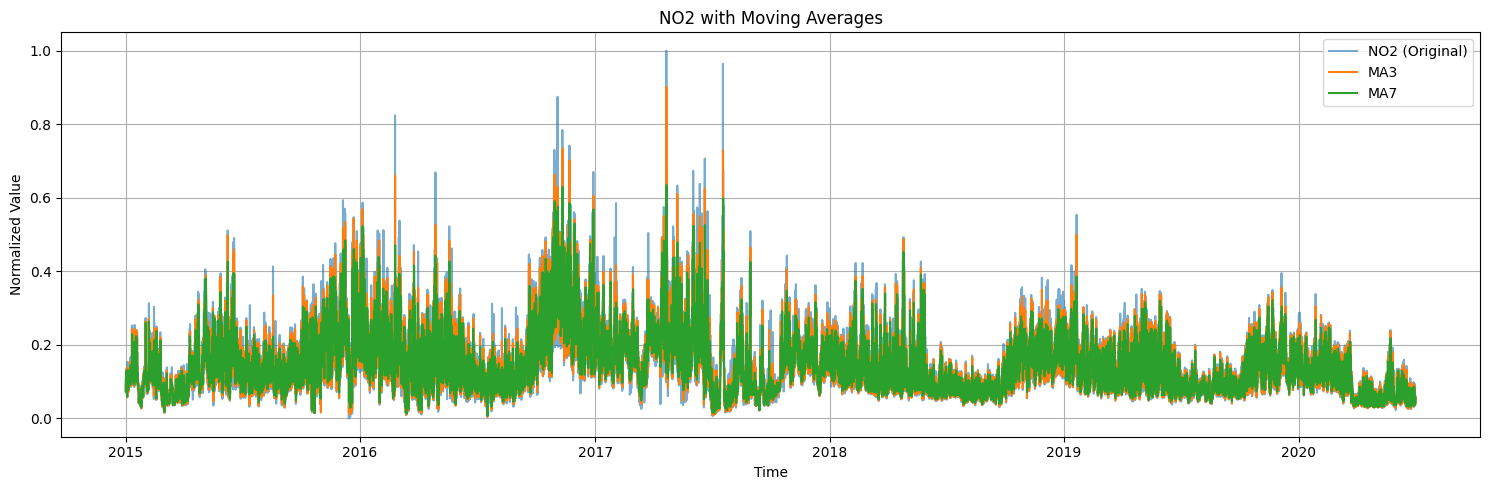

In [62]:
import matplotlib.pyplot as plt

def plot_moving_averages(df, feature, ma_windows=[3, 7]):
    plt.figure(figsize=(15, 5))
    plt.plot(df.index, df[feature], label=f'{feature} (Original)', alpha=0.6)

    for window in ma_windows:
        if f'{feature}_ma{window}' in df.columns:
            plt.plot(df.index, df[f'{feature}_ma{window}'], label=f'MA{window}')

    plt.title(f'{feature} with Moving Averages')
    plt.xlabel('Time')
    plt.ylabel('Normalized Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# PM2.5
plot_moving_averages(scaled_df, 'PM2.5')

# CO
plot_moving_averages(scaled_df, 'CO')

# NO2
plot_moving_averages(scaled_df, 'NO2')



In [63]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [64]:
model = Sequential()

# First LSTM Layer
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# Second LSTM Layer
model.add(LSTM(32))
model.add(Dropout(0.2))

# Output Layer
model.add(Dense(1))  # predicting PM2.5

# Compile Model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [65]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 24, 64)         │        23,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,489 (138.63 KB)

 Trainable params: 35,489 (138.63 KB)

 Non-trainable params: 0 (0.00 B)

In [66]:
early_stop = EarlyStopping(
    monitor='val_loss',     # we can also use 'val_mae'
    patience=5,             # Wait 5 epochs after no improvement
    restore_best_weights=True
)

In [67]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],   # <-- Added callback
    verbose=1
)

Epoch 1/100
964/964 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0045 - mae: 0.0436 - val_loss: 7.6177e-04 - val_mae: 0.0191
Epoch 2/100
964/964 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0018 - mae: 0.0262 - val_loss: 5.1336e-04 - val_mae: 0.0170
Epoch 3/100
964/964 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0015 - mae: 0.0233 - val_loss: 4.6522e-04 - val_mae: 0.0163
Epoch 4/100
964/964 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0014 - mae: 0.0222 - val_loss: 5.6282e-04 - val_mae: 0.0152
Epoch 5/100
964/964 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0014 - mae: 0.0223 - val_loss: 3.5823e-04 - val_mae: 0.0119
Epoch 6/100
964/964 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0014 - mae: 0.0217 - val_loss: 2.7777e-04 - val_mae: 0.0108
Epoch 7/100
964/964 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0013 - mae: 0.0209 - val_loss: 3.6195e-04 - val_mae: 0.0136
Epoch 8/100
964/964 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0013 - mae: 0.0208 - val_loss: 3.4030e-04 - val_mae: 0.0117
Epoch 9/100


In [68]:
loss, mae = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}, Test MAE: {mae:.4f}')

302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.8958e-04 - mae: 0.0087
Test Loss: 0.0002, Test MAE: 0.0095


In [69]:
y_pred = model.predict(X_test)

# Inverse transform to original scale for y_test
y_test_inv = scaler.inverse_transform(np.repeat(y_test.reshape(-1, 1), len(selected_features), axis=1))[:, 0] # Extract PM2.5

# Inverse transform to original scale for y_pred
y_pred_inv = scaler.inverse_transform(np.repeat(y_pred, len(selected_features), axis=1))[:, 0] # Extract PM2.5

302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


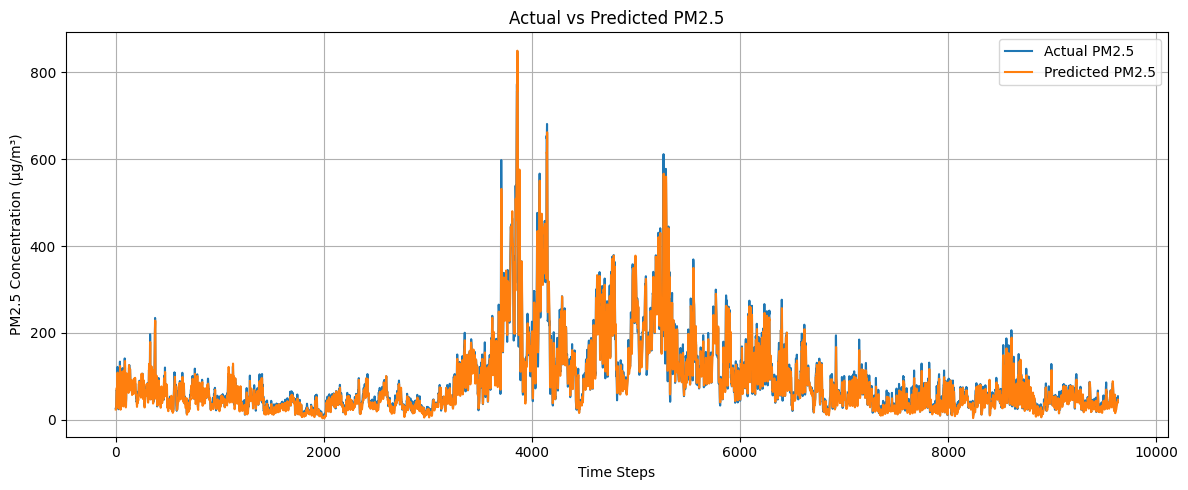

In [70]:
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv, label='Actual PM2.5')
plt.plot(y_pred_inv, label='Predicted PM2.5')
plt.title('Actual vs Predicted PM2.5')
plt.xlabel('Time Steps')
plt.ylabel('PM2.5 Concentration (µg/m³)')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

In [71]:
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R²   : {r2:.4f}")

MAE  : 8.92
RMSE : 14.14
R²   : 0.9746


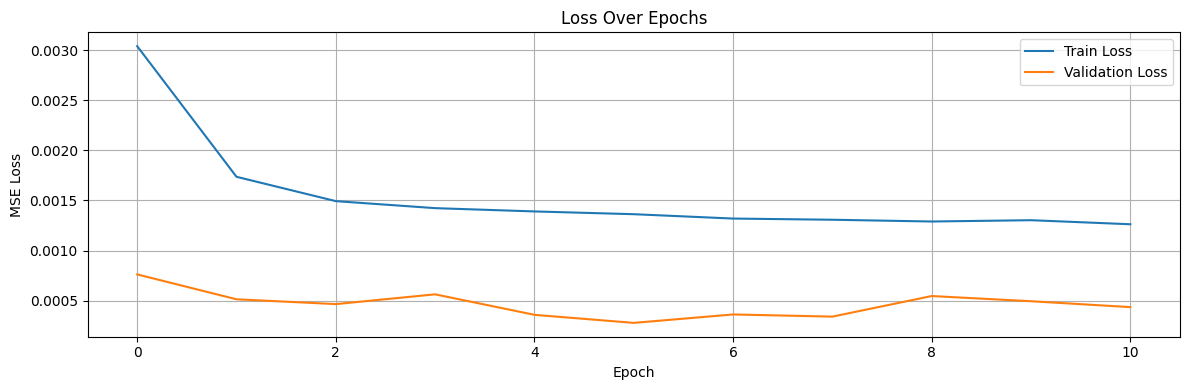

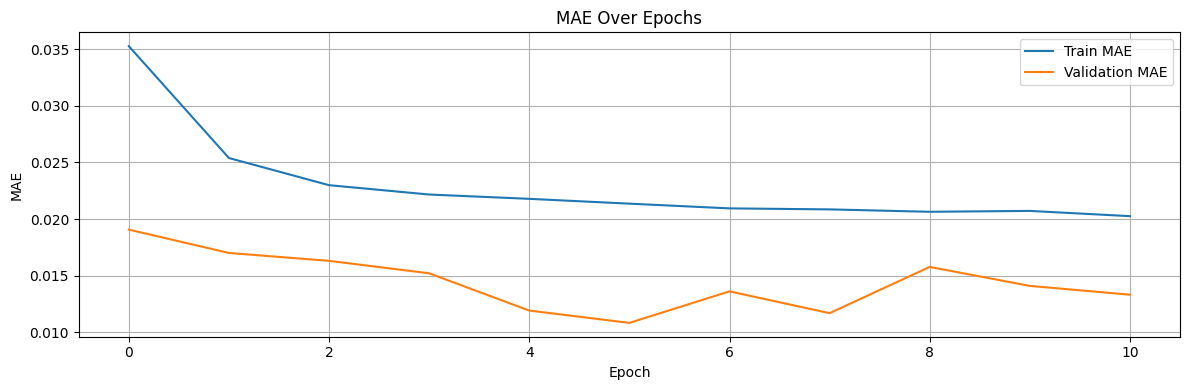

In [72]:
# Loss plot
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# MAE plot
plt.figure(figsize=(12, 4))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
